In [56]:
#Define functions

import pandas as pd
import numpy as np

#Import the data from the file
def read_data(filename):
    #Open file and read all first 11 lines
    data = open(filename)
    text = ''
    params = {}

    params1 = ['metric','fType']
    for i in range(2):
        row   = data.readline()
        text += row
        params.update({params1[i]:row.split(':')[1][1:-1]})
    params2 = ['p0','r0','d','q','deltaR']
    for i in range(5):
        row   = data.readline()
        text += row
        params.update({params2[i]:float(row.split(':')[1])})
    params3 = ['maxR','iterations','nP','time']
    for i in range(4):
        row   = data.readline()
        text += row
        params.update({params3[i]:int(row.split(':')[1])})
    params.update({'text':text})
    #Read data for R, phi, Phi and Pi
    rdata = list(map(float,(data.readline().split(','))[:-1]))
    alldata = data.readlines()
    data.close()
    len_5 = int(len(alldata)/5)
    if(len_5*5 !=len(alldata)):
        raise ValueError

    for i in range(5*len_5):
        alldata[i] = list(map(float,(alldata[i].split(','))[:-1]))
    fdata = alldata[:len_5]
    xdata = alldata[len_5:2*len_5]
    ydata = alldata[2*len_5:3*len_5]
    adata = alldata[3*len_5:4*len_5]
    bdata = alldata[4*len_5:]

    return rdata, fdata, xdata, ydata, adata, bdata, params

import matplotlib.animation as animation
import matplotlib.pyplot as plt

#Animation in paralel of scalar fields
def animate_data(filename, ipf = 1):
    r,f,x,y,a,b,params = read_data(filename)

    IPF = ipf #Iterations per frame
    iterations = len(f)
    if ipf>iterations:
        raise ValueError
    FRAMES = int(iterations/IPF)

    fig, ax = plt.subplots(3,2,figsize=(12,12),dpi=100)

    Fplot = ax[0,0].plot(r,f[0])[0]
    Xplot = ax[1,0].plot(r,x[0])[0]
    Yplot = ax[2,0].plot(r,y[0])[0]
    Aplot = ax[1,1].plot(r,a[0])[0]
    Bplot = ax[2,1].plot(r,b[0])[0]
    ax[0,0].text(1.21,0.98,params['text'],verticalalignment='top',transform=ax[0,0].transAxes)
    ax[0,1].remove()
    ax[1,0].set_ylim( -ax[0,0].get_ylim()[1],ax[0,0].get_ylim()[1])
    ax[2,0].set_ylim(  ax[0,0].get_ylim())
    #Make limits for phi plot based on maximum initial difference from external point
    deltaLim = max(f[0][-1] -ax[0,0].get_ylim()[0], ax[0,0].get_ylim()[1] -f[0][-1])
    ax[0,0].set_ylim(f[0][-1]-deltaLim,f[0][-1]+deltaLim)
    ax[0,0].set_title('$\phi$')
    ax[1,0].set_title('$\Phi$')
    ax[2,0].set_title('$\Pi$')
    ax[1,1].set_title('$a$')
    ax[2,1].set_title('$\\alpha$')

    #Create a function that changes the data every frame
    def animate(i):
        it = i*IPF
        Fplot.set_data(r,f[it])
        Xplot.set_data(r,x[it])
        Yplot.set_data(r,y[it])
        Aplot.set_data(r,a[it])
        Bplot.set_data(r,b[it])
        return None

    #Make the animation
    anim = animation.FuncAnimation(fig, animate, frames=FRAMES,
                                    interval=100, repeat_delay=3000)

    anim.save('newtest.gif',writer='pillow')

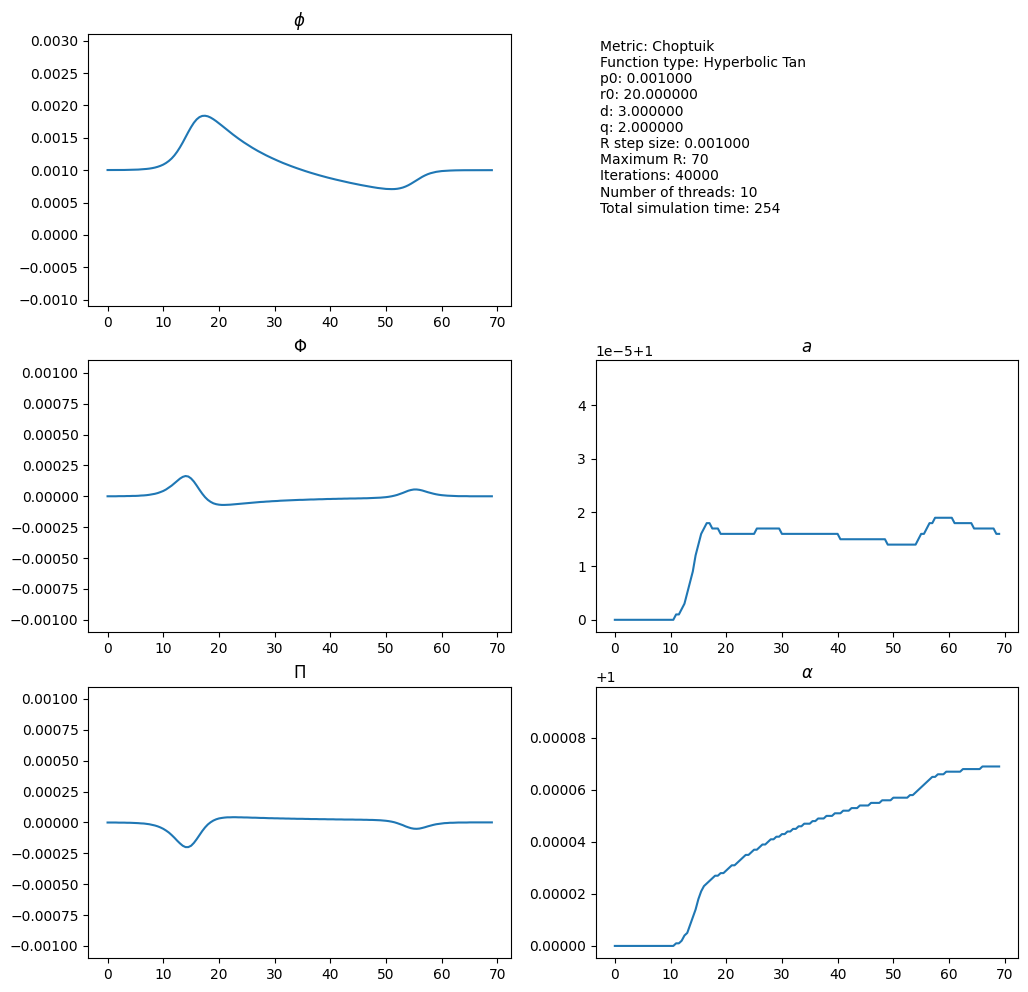

In [57]:
filename = "Output_210605.dat"

animate_data(filename,ipf=1)

## Parallelization performance

In [ ]:
#Parallel run

import subprocess
import time

fType = "0"
p0 = "0"
r0 = "0"
d  = "0"
q  = "0"
iterations = "20000"
maxR = "70"
processes = ["1","2","3","4","5","6","7","8","9","10","11","12"]
for p in processes:
    try:
        output = subprocess.check_output([".\Collapse.exe", fType, p0, r0, d, q, maxR, iterations, p], text=True,)
        print(f"Parallel execution:\n{output}")
    except subprocess.CalledProcessError as e:
        print(f"Parallel execution (supposedly an error):\n{e.output}")

In [8]:
#Read the last runs and compare performance
import pandas as pd
from os import listdir

#Search files
df = pd.DataFrame(columns=('Metric','Threads','Time','Iterations'))
folder_files = listdir()
folder_files = [f for f in folder_files if (f.startswith('Output') and f.endswith('.dat'))]
for file in folder_files:
    params = read_data(file)[4]
    new_row = pd.DataFrame([[params['metric'],params['nP'],params['time'],params['iterations']]],columns=('Metric','Threads','Time','Iterations'))
    df = pd.concat((df, new_row), ignore_index=True)

In [9]:
df

,Metric,Threads,Time,Iterations
0,Choptuik,1,182,20000
1,Choptuik,2,147,20000
2,Choptuik,3,139,20000
3,Choptuik,4,137,20000
4,Choptuik,5,133,20000
5,Choptuik,6,135,20000
6,Choptuik,7,135,20000
7,Choptuik,8,135,20000
8,Choptuik,9,134,20000
9,Choptuik,10,133,20000


## Test on different parameters

In [2]:
#Run for tanh function

import subprocess
import numpy as np

fType = "0"
p0s = np.logspace(-5,2,10)
r0 = "0"
d  = "0"
q  = "0"
iterations = "50000"
maxR = "70"
processes = "0"
for p0 in p0s:
    try:
        output = subprocess.check_output([".\Collapse.exe", fType, str(p0), r0, d, q, maxR, iterations, processes], text=True,)
        print(f"Parallel execution:\n{output}")
    except subprocess.CalledProcessError as e:
        print(f"Parallel execution (supposedly an error):\n{e.output}")

Parallel execution:
Total iterations: 50000
Finished

Parallel execution:
Total iterations: 50000
Finished

Parallel execution:
Total iterations: 50000
Finished

Parallel execution:
Total iterations: 50000
Finished

Parallel execution:
Total iterations: 50000
Finished

Parallel execution:
Total iterations: 50000
Finished

Parallel execution:
Total iterations: 50000
Finished

Parallel execution:
Total iterations: 50000
Finished

Parallel execution:
Total iterations: 50000
Finished

Parallel execution:
Total iterations: 50000
Finished



In [ ]:
#Run for exponential  function

import subprocess
import numpy as np

fType = "1"
p0s = np.logspace(-5,2,10)
r0 = "0"
d  = "0"
q  = "0"
iterations = "20000"
maxR = "70"
processes = "0"
for p0 in p0s:
    try:
        output = subprocess.check_output([".\Collapse.exe", fType, str(p0), r0, d, q, maxR, iterations, processes], text=True,)
        print(f"Parallel execution:\n{output}")
    except subprocess.CalledProcessError as e:
        print(f"Parallel execution (supposedly an error):\n{e.output}")